In [50]:
from matplotlib import pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, MaxPooling1D, UpSampling1D
from keras.layers.convolutional import Conv1D, Conv2D
from keras.optimizers import SGD, Adam
import medleydb as mdb
from scipy import signal
from scipy.io import wavfile

In [31]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

# Load the audio data

In [32]:
multitracks = mdb.load_multitracks([
    "Phoenix_ColliersDaughter", 
    "Phoenix_BrokenPledgeChicagoReel", 
    "Phoenix_ElzicsFarewell", 
    "Phoenix_LarkOnTheStrandDrummondCastle",
    "Phoenix_ScotchMorris",
    "Phoenix_SeanCaughlinsTheScartaglen"
])

In [33]:
mix_audio = None
instrument_audio = None

for mix in multitracks:
    sample_rate, song = wavfile.read(mix.mix_path)
    
    if mix_audio is None:
        mix_audio = song
    
    else:
        mix_audio = np.concatenate((mix_audio, song))
    
    #
    
    instruments = mdb.get_files_for_instrument("violin", [mix])

    instrument = next(instruments)
    
    sample_rate, track = wavfile.read(instrument)
    
    if instrument_audio is None:
        instrument_audio = track
    
    else:
        instrument_audio = np.concatenate((instrument_audio, track))
    
mix_audio = mix_audio.mean(1)
instrument_audio = instrument_audio.mean(1)

In [34]:
samples_per_period = 256
overlap = int(samples_per_period/2)

# Process the Mix

In [89]:
freqs, times, s_mix = signal.stft(mix_audio, fs=sample_rate, nfft=samples_per_period, 
                                         noverlap=overlap, nperseg=samples_per_period)

freqs = freqs[:-1]
s_mix = s_mix[:-1,:]

In [90]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_mix)))
#plt.title("STFT of the Mix")
#plt.ylabel("Frequency (Hz)")
#plt.xlabel("Time (s)")

# Process the Target Instrument

In [91]:
_, _, s_instrument = signal.stft(instrument_audio, fs=sample_rate, nfft=samples_per_period, 
                                               noverlap=overlap, nperseg=samples_per_period)

s_instrument = s_instrument[:-1,:]

s_instrument += 1e-9

In [38]:
#plt.pcolormesh(times, freqs, 20*np.log10(np.abs(s_instrument)))
#plt.title("STFT of the instrument Track")
#plt.xlabel("Time (s)")
#plt.ylabel("Frequency (Hz)")

# Prepare the training data

In [41]:
num_test  = int((sample_rate * 120)/samples_per_period)
num_train = s_mix.shape[1] - num_test
print(num_train, num_test)

374742 20671


In [42]:
mix_train = s_mix.T[:num_train,:,np.newaxis]
mix_train = np.concatenate((mix_train.real, mix_train.imag), axis=-1)
mix_train.shape

(374742, 128, 2)

In [44]:
instrument_train = s_instrument.T[:num_train,:,np.newaxis]
instrument_train = np.concatenate((instrument_train.real, instrument_train.imag), axis=-1)
instrument_train.shape

(374742, 128, 2)

In [45]:
mix_test = s_mix.T[-num_test:,:,np.newaxis]
mix_test = np.concatenate((mix_test.real, mix_test.imag), axis=-1)
mix_test.shape

(20671, 128, 2)

In [47]:
instrument_test = s_instrument.T[-num_test:,:,np.newaxis]
instrument_test = np.concatenate((instrument_test.real, instrument_test.imag), axis=-1)
instrument_test.shape

(20671, 128, 2)

In [48]:
model = Sequential()

model.add(Conv1D(100, 2, padding="same", input_shape=mix_train.shape[1:], activation="relu", name="Conv1D_1"))

model.add(Conv1D(100, 2, padding="same",  activation="relu", name="Conv1D_2"))

model.add(Conv1D(100, 2, padding="same",  activation="relu", name="Conv1D_3"))

model.add(Conv1D(2, 2, padding="same",  name="Conv1D_7"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 128, 100)          500       
_________________________________________________________________
Conv1D_2 (Conv1D)            (None, 128, 100)          20100     
_________________________________________________________________
Conv1D_3 (Conv1D)            (None, 128, 100)          20100     
_________________________________________________________________
Conv1D_7 (Conv1D)            (None, 128, 2)            402       
Total params: 41,102
Trainable params: 41,102
Non-trainable params: 0
_________________________________________________________________


In [51]:
adam = Adam(lr=1e-3, beta_1=0.95, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

#sgd = SGD(lr=0.001, momentum=1.1, decay=1.1, nesterov=True)

model.compile(adam, loss='mean_squared_error', metrics=['accuracy'])

In [52]:
history = model.fit(mix_train, instrument_train, batch_size=1000, epochs=10)

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Epoch 1/10
374742/374742 [==============================] - 23s 62us/step - loss: 1930.9145 - acc: 0.6455
Epoch 2/10
374742/374742 [==============================] - 21s 56us/step - loss: 1838.3708 - acc: 0.6431
Epoch 3/10
374742/374742 [==============================] - 21s 56us/step - loss: 1803.3233 - acc: 0.6255
Epoch 4/10
374742/374742 [==============================] - 21s 56us/step - loss: 1779.7559 - acc: 0.6175
Epoch 5/10
374742/374742 [==============================] - 21s 56us/step - loss: 1765.7765 - acc: 0.6121
Epoch 6/10
374742/374742 [==============================] - 21s 56us/step - loss: 1756.8040 - acc: 0.6106
Epoch 7/10
374742/374742 [==============================] - 21s 56us/step - loss: 1750.4922 - acc: 0.6133
Epoch 8/10
374742/374742 [==============================] - 21s 56us/step - loss: 1743.6698 - acc: 0.6120
Epoch 9/10
374742/374742 [==============================] - 21s 56us/step - loss: 1740.0399 - acc: 0.6150
Epoch 10/10
374742/374742 [===================

In [53]:
results = model.evaluate(mix_test, instrument_test)

print(model.metrics_names)
print(results)

20671/20671 [==============================] - 1s 60us/step
['loss', 'acc']
[2081.5982965585163, 0.6385402556375959]


# Results

In [106]:
prediction = model.predict(mix_test)
prediction.shape

(20671, 128, 2)

In [107]:
target = s_instrument[:, -num_test:]

In [108]:
prediction = (prediction[:,:,0]+prediction[:,:,1] * 1j).T

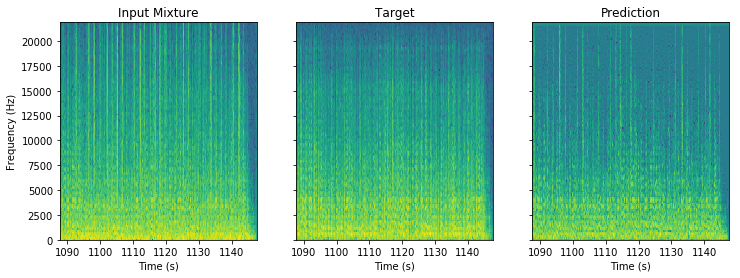

In [109]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))

ax1.set_title("Input Mixture")
ax2.set_title("Target")
ax3.set_title("Prediction")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlabel("Time (s)")
ax2.set_xlabel("Time (s)")
ax3.set_xlabel("Time (s)")

ax1.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(s_mix[:,-num_test:])))
ax2.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(target)))
ax3.pcolormesh(times[-num_test:], freqs, 20*np.log10(np.abs(prediction)))

## Let's hear it

In [110]:
_, predicted_audio = signal.istft(prediction, fs=sample_rate)
_, target_audio = signal.istft(target, fs=sample_rate)
_, mix_audio = signal.istft(s_mix[:,-num_test:], fs=sample_rate)

wavfile.write("deep_conv_model_instrument_prediction.wav", sample_rate, predicted_audio.astype(np.int16))
wavfile.write("deep_conv_model_instrument_target.wav", sample_rate, target_audio.astype(np.int16))
wavfile.write("deep_conv_model_original.wav", sample_rate, mix_audio.astype(np.int16))